In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from ops import linear

In [2]:
sess = tf.InteractiveSession()

In [3]:
batch_size = 100
input_size = 1
output_size = 2

In [4]:
z = tf.placeholder(tf.float32, [None, input_size], name='z')
layer_input = z
stddev = 0.5
for i, layer_size in enumerate([16, 16]):
    output = tf.nn.relu(linear(layer_input, layer_size, scope="g_{0}".format(i), stddev=stddev))
    layer_input = output
g_output = linear(layer_input, output_size, scope="g_final", stddev=stddev)

In [5]:
""" 
Create two discriminators reusing the variables for each but 
different inputs and outputs. The reason for this is as follows:
We want to allow gradients to flow from the discriminator output
back to the generator in order for the generator to get a signal 
of how to do better. Hence we'd like the g_output to be an input
to D. Additionally we need to be able to feed D examples generated 
from the true distribution, i.e. its input should be a placeholder, 
which takes in values (numbers) rather than nodes (variables). We 
can't use placeholders for parameters that need to be learned, 
hence there are two separate inputs to D with two outputs, but only 
one D.
"""
discriminator_layers = [8, 8]
layer_input = tf.placeholder(tf.float32, [batch_size, output_size], name='real_data')
real_data_input = layer_input
for i, layer_size in enumerate(discriminator_layers):
    output = tf.nn.relu(linear(layer_input, layer_size, scope="d_{0}".format(i)))
    layer_input = output
d_output_real = linear(layer_input, 1, scope="d_final")
# Discriminator that takes real data
tf.get_variable_scope().reuse_variables()
layer_input = g_output
for i, layer_size in enumerate(discriminator_layers):
    # This looks up the variable with tf.get_variable, allowing reuse
    output = tf.nn.relu(linear(layer_input, layer_size, scope="d_{0}".format(i)))
    layer_input = output
# This doesn't use get_variable and is new.
d_output_fake = linear(layer_input, 1, scope="d_final")

In [6]:
# Now we define two discriminator losses, based on the fake and real discriminator predictions.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_real, tf.ones_like(d_output_real)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_fake, tf.zeros_like(d_output_fake)))
d_loss = tf.add(d_loss_real, d_loss_fake)
# And the generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_fake, tf.ones_like(d_output_fake)))

In [7]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

d_optim = tf.train.AdamOptimizer(0.01, beta1=0.5).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(0.0005, beta1=0.5).minimize(g_loss, var_list=g_vars)
tf.initialize_all_variables().run()

<IPython.core.display.Javascript object>


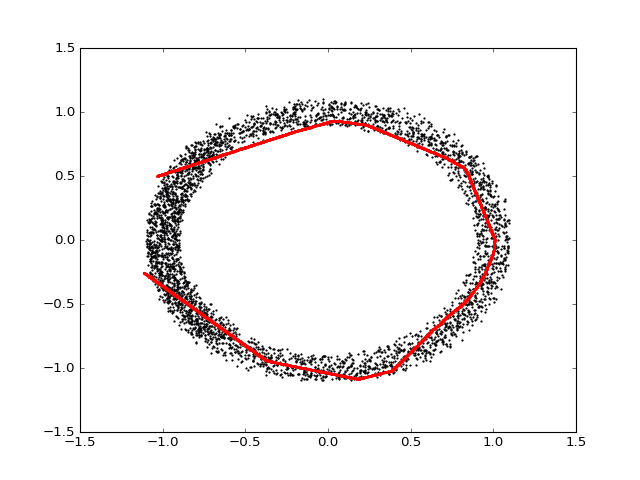

loss 0.345916 0.415784 1.20399
loss 0.405223 0.317429 1.47391
loss 0.393491 0.240526 1.61256
loss 0.400522 0.233019 1.87855
loss 0.395397 0.356088 1.34433
loss 0.547306 0.340405 1.29753
loss 0.45364 0.432353 1.07732
loss 0.578783 0.372634 1.2241
loss 0.481144 0.516054 1.04353
loss 0.424632 0.481733 1.13496
loss 0.62338 0.506471 1.04003
loss 0.668331 0.735819 0.787428
loss 0.55883 0.683556 0.720144
loss 0.538844 0.739103 0.726304
loss 0.515518 0.598678 0.840516
loss 0.582142 0.661596 0.779503
loss 0.554816 0.625557 0.845101
loss 0.4557 0.782391 0.661885
loss 0.553332 0.657093 0.766818
loss 0.534989 0.632358 0.794188
loss 0.542419 0.606394 0.822856
loss 0.545108 0.623945 0.797199
loss 0.568801 0.557696 0.913254
loss 0.474892 0.69812 0.762684
loss 0.557718 0.600796 0.815251
loss 0.524958 0.644487 0.782287
loss 0.511833 0.68993 0.758362


KeyboardInterrupt: 

In [8]:
%matplotlib notebook
import time

fig,ax = plt.subplots(1,1)
counter = 0
data = [[math.cos(x/500)+(np.random.uniform()-0.5)/5, math.sin(x/500)+(np.random.uniform()-0.5)/5] for x in range(-2000, 2000)]
np.random.shuffle(data)
z_data = np.random.uniform(-1, 1, [4000, input_size]).astype(np.float32)
for epoch in range(500):
    batch_idxs = len(data)//batch_size
    for idx in range(0, batch_idxs):
        real_data_batch = np.array(data[idx*batch_size:(idx+1)*batch_size]).astype(np.float32)
        batch_z = np.random.uniform(-1, 1, [batch_size, input_size]).astype(np.float32)
        sess.run([d_optim], feed_dict={ z: batch_z, real_data_input: real_data_batch })
        sess.run([g_optim], feed_dict={ z: batch_z })
    if epoch%1 == 0:
        print("loss", 
              d_loss_real.eval({real_data_input: real_data_batch}), 
              d_loss_fake.eval({z: batch_z}),
              g_loss.eval({z: batch_z}))        
        
        ax.clear()
        ax.scatter([g[0] for g in data], [g[1] for g in data], s=1)
        gen = g_output.eval({z: z_data})
        ax.scatter([g[0] for g in gen], [g[1] for g in gen], color=[1,0,0,1], s=2)
        fig.canvas.draw()
        fig.savefig('videos/test%03d.png' % counter, format='png')
        counter += 1
